In [2]:
# new accuracy & precision plots; 
# collect all data so that no other loading of data would be needed. 
import collections

import compress_pickle
import copy
import editdistance
import itertools
import libsbml
import numpy as np
import os
import pickle
import pandas as pd
import sys
import time
import matplotlib.pyplot as plt
%matplotlib inline  

BIOMD_12 = 'BIOMD0000000012.xml'
BASE_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/'
DATA_DIR = os.path.join(BASE_DIR, "DATA")
ALGO_DIR = os.path.join(DATA_DIR, "algo")
CHEBI_DIR = os.path.join(DATA_DIR, "chebi")
FIGURE_DIR = '/Users/woosubshin/Desktop/AutomateAnnotation/AMAS_suppl/figure_files'
RHEA_DIR = os.path.join(DATA_DIR, "rhea")
BIOMODEL_DIR = os.path.join(DATA_DIR, "biomodels/curated_biomodels_31mar2021")
BIGG_DIR = '/Users/woosubshin/Desktop/AutomateAnnotation/DATA/bigg'
ecoli_fpath = os.path.join(BIGG_DIR, "e_coli_core.xml")

PROJ_DIR = os.path.join(os.getcwd(), os.pardir)
AMAS_DIR = os.path.join(PROJ_DIR, "AMAS")
sys.path.append(PROJ_DIR)

SUPPL_DIR = os.path.join(PROJ_DIR, os.pardir, "AMAS_suppl")
ACCURACY_DIR = os.path.join(SUPPL_DIR, "data_for_credibility")

FIGURE_DIR = '/Users/woosubshin/Desktop/AutomateAnnotation/AMAS_suppl/figure_files'
TEMPFIG_DIR = os.path.join(FIGURE_DIR, 'temp')

from AMAS import species_annotation as sa
from AMAS import reaction_annotation as ra
from AMAS import recommender
from AMAS import constants as cn
from AMAS import iterator as it
from AMAS import tools

biggs = [val for val in os.listdir(BIGG_DIR) if val[-4:]=='.xml']
print("Number of BiGG models to be analyzed: %d" % len(biggs))

spec_ml_df = pd.read_csv(os.path.join(ACCURACY_DIR, 'biomd_individual_species_accuracy.csv'))
biomds_spec = np.unique(spec_ml_df['model'])
print("Number of BioModels to be analyzed for SPECIES: %d" % len(biomds_spec))

reac_ml_df = pd.read_csv(os.path.join(ACCURACY_DIR, 'biomd_individual_reactions_accuracy.csv'))
biomds_reac = np.unique(reac_ml_df['model'])
print("Number of BioModels to be analyzed for REACTIONS: %d" % len(biomds_reac))

Number of BiGG models to be analyzed: 108
Number of BioModels to be analyzed for SPECIES: 306
Number of BioModels to be analyzed for REACTIONS: 131


## 1. Data & Plots for BioModels Species

In [2]:
# First data; BioModels Species

model_names = []
len_names = []
num_cands = []
num_formulas = []
match_scores = []
is_correct_included = []
total_recalls = []
total_precisions = []
#
for idx, one_biomd in enumerate(biomds_spec):
  if idx % 100 == 0:
    print("We are at", idx)
  one_fpath = os.path.join(BIOMODEL_DIR, one_biomd)
  recom = recommender.Recommender(libsbml_fpath=one_fpath)
  specs2evaluate = list(recom.species.exist_annotation_formula.keys())
  # run algorithm if there is at least one species to evaluate
  if specs2evaluate:
    recoms = recom.getSpeciesListRecommendation(pred_ids=recom.species.exist_annotation_formula.keys())
    # statistics
    refs = {val:recom.species.exist_annotation_formula[val] \
            for val in specs2evaluate}
    
    preds_raw = {val.id: [k[0] for k in val.candidates] for val in recoms}

    preds = {k: list(set([cn.REF_CHEBI2FORMULA[k] for k in preds_raw[k] if k in cn.REF_CHEBI2FORMULA.keys()])) \
             for k in preds_raw.keys()}
    recalls = tools.getRecall(ref=refs, pred=preds, mean=False)
    precisions = tools.getPrecision(ref=refs, pred=preds, mean=False)

    # one_recom per each species
    for one_recom in recoms:
      model_names.append(one_biomd)
      one_spec = one_recom.id
      len_names.append(len(recom.species.getNameToUse(one_spec)))
      num_cands.append(len(one_recom.candidates))
      num_formulas.append(len(recom.species.formula[one_recom.id]))
      match_scores.append(one_recom.candidates[0][1])
      if recalls[one_spec] > 0:
        is_correct_included.append(1)
      else:
        is_correct_included.append(0)
      total_recalls.append(recalls[one_spec])
      total_precisions.append(precisions[one_spec])

biomd_spec_df = pd.DataFrame({'model': model_names,
                              'name_length': len_names,
                              'num_candidates': num_cands,
                              'num_formulas': num_formulas,
                              'match_score': match_scores,
                              'accuracy': is_correct_included,
                              'recall': total_recalls,
                              'precision': total_precisions})

We are at 0
We are at 100
We are at 200
We are at 300


In [4]:
biomd_spec_df.head()

,model,name_length,num_candidates,num_formulas,match_score,accuracy,recall,precision
0,BIOMD0000000002.xml,3,2,2,1.000,1,1.0,0.500
1,BIOMD0000000013.xml,5,4,3,0.866,1,1.0,0.333
2,BIOMD0000000013.xml,6,6,6,0.894,0,0.0,0.000
3,BIOMD0000000013.xml,10,2,1,0.849,1,1.0,1.000
4,BIOMD0000000013.xml,6,1,1,0.868,0,0.0,0.000


In [4]:
biomd_spec_df.shape

(4902, 8)

In [3]:
# biomd_spec_df.to_csv(os.path.join(ACCURACY_DIR, 'biomd_species_plot_data.csv'), index=False)

biomd_spec_df = pd.read_csv(os.path.join(ACCURACY_DIR, 'biomd_species_plot_data.csv'))
biomd_spec_df.shape

(4902, 8)

In [6]:
def draw_plot(df, degen_col, val_col, x_label, save_path):
  """
  Draw a plot and save it
  
  Parameters
  ----------
  df: pandas.DataFrame
  
  degen_col: str
      Column name for degenerate case
      
  val_col: str
      Column name for values to summarize
      
  x_lavel: str
      Name of X axis
  
  save_path: str
      File path to save it. 
  """
  cutoffs = np.arange(0.0, 1.05, step=0.001)
  vals = dict()

  for one_degen in range(0, 5):
    ys = []
    xs = []
    val_tuples = []
    cut_df = df[df[degen_col]>one_degen]
    for one_c in cutoffs:
      xs.append(one_c)
      sub_df = cut_df[cut_df['match_score']>=one_c]
      prop_or_mean_value = np.mean(sub_df[val_col])
      ys.append(prop_or_mean_value)
      val_tuples.append((one_c, prop_or_mean_value))
    vals[str(one_degen)] = val_tuples
    plt.scatter(xs, ys, s=5, label='reject: <=%d'%one_degen)
  plt.legend(loc='lower left')
  plt.ylim([-0.05,1.05])
  plt.xlabel(x_label)
  plt.ylabel(val_col)
  plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.0)
  plt.show()

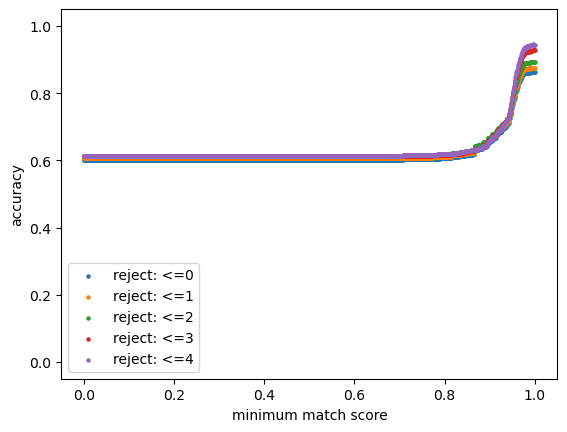

In [7]:
draw_plot(df=biomd_spec_df,
          degen_col='name_length',
          val_col='accuracy',
          x_label='minimum match score',
          save_path=os.path.join(TEMPFIG_DIR, 'biomd_species_accuracy.png'))

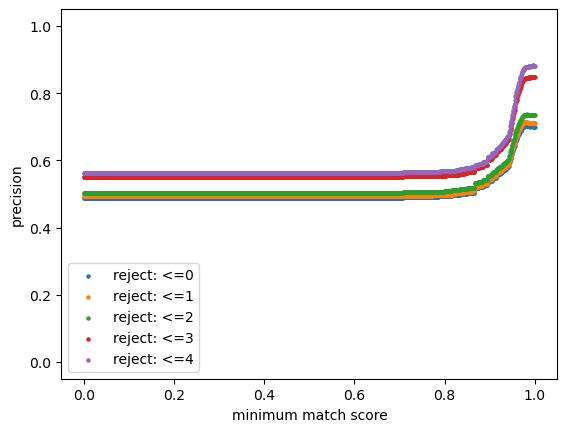

In [9]:
draw_plot(df=biomd_spec_df,
          degen_col='name_length',
          val_col='precision',
          x_label='minimum match score',
          save_path=os.path.join(TEMPFIG_DIR, 'biomd_species_precision.png'))

## 2. Data & Plots for BioModels Reactions

In [10]:
def getRheaElementNum(inp_rhea, inp_df=ra.REF_MAT):
  """
  Get Number of elements of
  the given rhea term.
  
  Parameters
  ----------
  inp_rhea: str
  
  Returns
  -------
  : int
  """
  return len(inp_df.loc[inp_rhea, :].to_numpy().nonzero()[0])

model_names = []
num_rhea_eles = []
num_query_eles = []
num_candidates = []
val_match_scores = []
is_correct_included = []
total_recalls = []
total_precisions = []


for idx, one_biomd in enumerate(biomds_reac):
  if idx % 50 == 0:
    print("We are at", idx)
  one_fpath = os.path.join(BIOMODEL_DIR, one_biomd)
  recom = recommender.Recommender(libsbml_fpath=one_fpath)
  reac2evaluate = list(recom.reactions.exist_annotation.keys())
  if reac2evaluate:  
    recoms = recom.getReactionListRecommendation(pred_ids=reac2evaluate)
    
    refs = {val:recom.reactions.exist_annotation[val] \
            for val in reac2evaluate}   
    preds = {val.id: [k[0] for k in val.candidates] for val in recoms}

    recalls = tools.getRecall(ref=refs, pred=preds, mean=False)
    precisions = tools.getPrecision(ref=refs, pred=preds, mean=False)

    for one_recom in recoms:
      one_reac = one_recom.id
      match_scores = [val[1] for val in one_recom.candidates]
      num_ref_elements = [getRheaElementNum(val[0]) for val in one_recom.candidates]
      #
      mean_num_rhea_elements = np.mean(num_ref_elements)   
      # this is actually the number of reaction components;
      num_query_ele = len(recom.reactions.reaction_components[one_reac])
      num_cands = len(match_scores)
      mean_match_score = np.mean(match_scores)
      #
      model_names.append(one_biomd)
      num_rhea_eles.append(mean_num_rhea_elements)
      num_query_eles.append(num_query_ele)
      num_candidates.append(num_cands)
      val_match_scores.append(mean_match_score)
      if recalls[one_reac] > 0.0:
        is_correct_included.append(1)
      else:
        is_correct_included.append(0)
      total_recalls.append(recalls[one_reac])
      total_precisions.append(precisions[one_reac])
        
biomd_reac_df = pd.DataFrame({'model': model_names,
                              'mean_num_rhea_elements': num_rhea_eles,
                              'num_query_elements': num_query_eles,
                              'num_candidates': num_candidates,
                              'match_score': val_match_scores,
                              'accuracy': is_correct_included,
                              'recall': total_recalls,
                              'precision': total_precisions})
biomd_reac_df.head()

We are at 0
We are at 50
We are at 100


,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy,recall,precision
0,BIOMD0000000003.xml,4.650943,1,106,0.242528,0,0.0,0.0
1,BIOMD0000000003.xml,4.650943,1,106,0.242528,0,0.0,0.0
2,BIOMD0000000004.xml,4.693548,2,248,0.233302,0,0.0,0.0
3,BIOMD0000000004.xml,4.693548,2,248,0.233302,0,0.0,0.0
4,BIOMD0000000005.xml,4.272727,2,22,0.292455,0,0.0,0.0


In [11]:
biomd_reac_df.shape

(2188, 8)

In [5]:
# biomd_reac_df.to_csv(os.path.join(ACCURACY_DIR, 'biomd_reactions_plot_data.csv'), index=False)

biomd_reac_df = pd.read_csv(os.path.join(ACCURACY_DIR, 'biomd_reactions_plot_data.csv'))
biomd_reac_df.shape

(2188, 8)

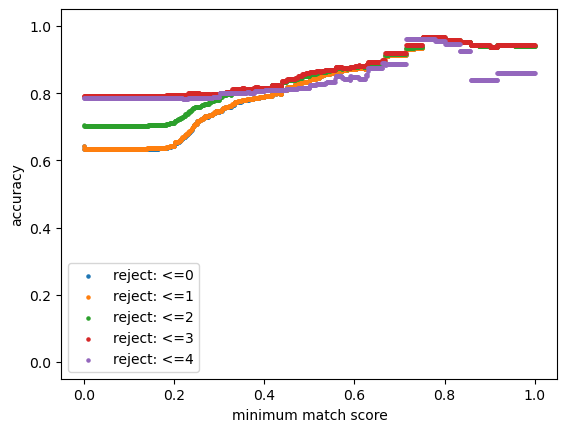

In [13]:
draw_plot(df=biomd_reac_df,
          degen_col='num_query_elements',
          val_col='accuracy',
          x_label='minimum match score',
          save_path=os.path.join(TEMPFIG_DIR, 'biomd_reactions_accuracy.png'))

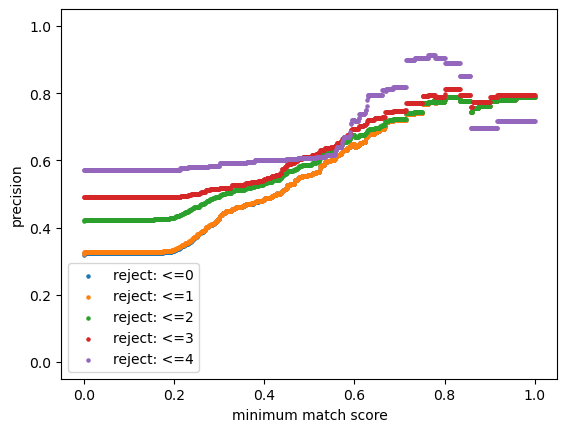

In [14]:
draw_plot(df=biomd_reac_df,
          degen_col='num_query_elements',
          val_col='precision',
          x_label='minimum match score',
          save_path=os.path.join(TEMPFIG_DIR, 'biomd_reactions_precision.png'))

## 3. Data & Plots for BiGG Species

In [15]:
# BiGG Species

model_names = []
len_names = []
num_cands = []
num_formulas = []
match_scores = []
is_correct_included = []
total_recalls = []
total_precisions = []
#
for idx, one_bigg in enumerate(biggs):
  if idx % 10 == 0:
    print("We are at", idx)
  one_fpath = os.path.join(BIGG_DIR, one_bigg)
  recom = recommender.Recommender(libsbml_fpath=one_fpath)
  specs2evaluate = list(recom.species.exist_annotation_formula.keys())
  # run algorithm if there is at least one species to evaluate
  if specs2evaluate:
    recoms = recom.getSpeciesListRecommendation(pred_ids=recom.species.exist_annotation_formula.keys())
    # statistics
    refs = {val:recom.species.exist_annotation_formula[val] \
            for val in specs2evaluate}
    
    preds_raw = {val.id: [k[0] for k in val.candidates] for val in recoms}

    preds = {k: list(set([cn.REF_CHEBI2FORMULA[k] for k in preds_raw[k] if k in cn.REF_CHEBI2FORMULA.keys()])) \
             for k in preds_raw.keys()}
    recalls = tools.getRecall(ref=refs, pred=preds, mean=False)
    precisions = tools.getPrecision(ref=refs, pred=preds, mean=False)

    # one_recom per each species
    for one_recom in recoms:
      model_names.append(one_bigg)
      one_spec = one_recom.id
      len_names.append(len(recom.species.getNameToUse(one_spec)))
      num_cands.append(len(one_recom.candidates))
      num_formulas.append(len(recom.species.formula[one_recom.id]))
      match_scores.append(one_recom.candidates[0][1])
      if recalls[one_spec] > 0:
        is_correct_included.append(1)
      else:
        is_correct_included.append(0)
      total_recalls.append(recalls[one_spec])
      total_precisions.append(precisions[one_spec])

bigg_spec_df = pd.DataFrame({'model': model_names,
                             'name_length': len_names,
                             'num_candidates': num_cands,
                             'num_formulas': num_formulas,
                             'match_score': match_scores,
                             'accuracy': is_correct_included,
                             'recall': total_recalls,
                             'precision': total_precisions})
bigg_spec_df.head()

We are at 0
We are at 10
We are at 20
We are at 30
We are at 40
We are at 50
We are at 60
We are at 70
We are at 80
We are at 90
We are at 100


,model,name_length,num_candidates,num_formulas,match_score,accuracy,recall,precision
0,iCHOv1.xml,23,3,1,1.000,1,1.0,1.0
1,iCHOv1.xml,23,3,1,1.000,1,1.0,1.0
2,iCHOv1.xml,25,1,1,1.000,1,1.0,1.0
3,iCHOv1.xml,23,3,1,1.000,1,1.0,1.0
4,iCHOv1.xml,27,1,1,0.958,0,0.0,0.0


In [6]:
# bigg_spec_df.to_csv(os.path.join(ACCURACY_DIR, 'bigg_species_plot_data.csv'), index=False)

bigg_spec_df = pd.read_csv(os.path.join(ACCURACY_DIR, 'bigg_species_plot_data.csv'))
bigg_spec_df.shape

(133233, 8)

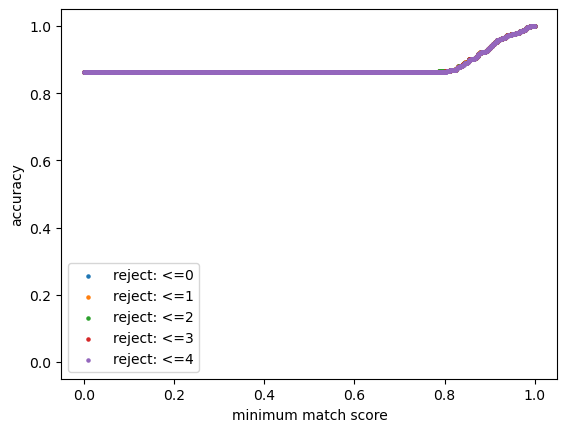

In [123]:
draw_plot(df=bigg_spec_df,
          degen_col='name_length',
          val_col='accuracy',
          x_label='minimum match score',
          save_path=os.path.join(TEMPFIG_DIR, 'bigg_species_accuracy.png'))

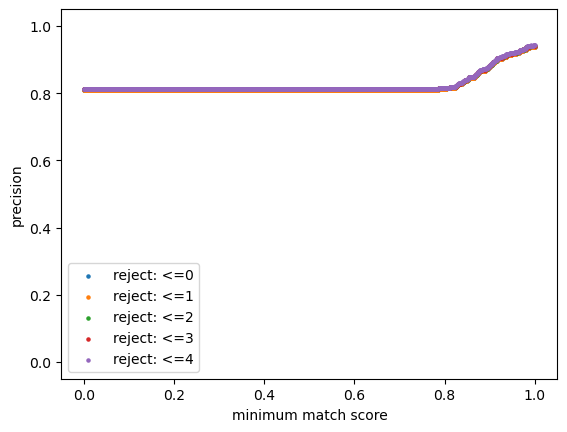

In [124]:
draw_plot(df=bigg_spec_df,
          degen_col='name_length',
          val_col='precision',
          x_label='minimum match score',
          save_path=os.path.join(TEMPFIG_DIR, 'bigg_species_precision.png'))

In [21]:
# TODO: (1) DO THE SAME THING WITH (one bigg model with about 1000 species?!
# as 108/306 models wanted to be added
# (2) do the same two plots of reactions

In [22]:
# num_bigg_specs = []
# num_bigg_reacs = []
# for idx, one_biomd in enumerate(biggs):
#   if idx % 30 == 0:
#     print("We are at", idx)
#   one_fpath = os.path.join(BIGG_DIR, one_biomd)
#   recom = recommender.Recommender(libsbml_fpath=one_fpath)
#   specs2evaluate = list(recom.species.exist_annotation_formula.keys())
#   reacs2evaluate = list(recom.reactions.exist_annotation.keys())
#   num_bigg_specs.append(len(specs2evaluate))
#   num_bigg_reacs.append(len(reacs2evaluate))

In [23]:
# bigg_df = pd.DataFrame(zip(biggs, num_bigg_specs, num_bigg_reacs), columns=['model', 'species', 'reactions'])
# bigg_df.head()

## 4. Data & Plots for BiGG Reactions

In [24]:
# BiGG reactions (by predicting species annotations)
model_names = []
num_rhea_eles = []
num_query_eles = []
num_candidates = []
val_match_scores = []
is_correct_included = []
total_recalls = []
total_precisions = []


for idx, one_bigg in enumerate(biggs):
  if idx % 10 == 0:
    print("We are at", idx)
  one_fpath = os.path.join(BIGG_DIR, one_bigg)
  recom = recommender.Recommender(libsbml_fpath=one_fpath)
  reac2evaluate = list(recom.reactions.exist_annotation.keys())
  if reac2evaluate:  
    recoms = recom.getReactionListRecommendation(pred_ids=reac2evaluate)
    
    refs = {val:recom.reactions.exist_annotation[val] \
            for val in reac2evaluate}   
    preds = {val.id: [k[0] for k in val.candidates] for val in recoms}

    recalls = tools.getRecall(ref=refs, pred=preds, mean=False)
    precisions = tools.getPrecision(ref=refs, pred=preds, mean=False)

    for one_recom in recoms:
      one_reac = one_recom.id
      match_scores = [val[1] for val in one_recom.candidates]
      num_ref_elements = [getRheaElementNum(val[0]) for val in one_recom.candidates]
      #
      mean_num_rhea_elements = np.mean(num_ref_elements)   
      # this is actually the number of reaction components;
      num_query_ele = len(recom.reactions.reaction_components[one_reac])
      num_cands = len(match_scores)
      mean_match_score = np.mean(match_scores)
      #
      model_names.append(one_bigg)
      num_rhea_eles.append(mean_num_rhea_elements)
      num_query_eles.append(num_query_ele)
      num_candidates.append(num_cands)
      val_match_scores.append(mean_match_score)
      if recalls[one_reac] > 0.0:
        is_correct_included.append(1)
      else:
        is_correct_included.append(0)
      total_recalls.append(recalls[one_reac])
      total_precisions.append(precisions[one_reac])
        
bigg_reac_df_pred = pd.DataFrame({'model': model_names,
                                  'mean_num_rhea_elements': num_rhea_eles,
                                  'num_query_elements': num_query_eles,
                                  'num_candidates': num_candidates,
                                  'match_score': val_match_scores,
                                  'accuracy': is_correct_included,
                                  'recall': total_recalls,
                                  'precision': total_precisions})
bigg_reac_df_pred.head()

We are at 0
We are at 10
We are at 20
We are at 30
We are at 40
We are at 50
We are at 60
We are at 70
We are at 80
We are at 90
We are at 100


,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy,recall,precision
0,BIOMD0000000003.xml,4.650943,1,106,0.242528,0,0.0,0.0
1,BIOMD0000000003.xml,4.650943,1,106,0.242528,0,0.0,0.0
2,BIOMD0000000004.xml,4.693548,2,248,0.233302,0,0.0,0.0
3,BIOMD0000000004.xml,4.693548,2,248,0.233302,0,0.0,0.0
4,BIOMD0000000005.xml,4.272727,2,22,0.292455,0,0.0,0.0


In [30]:
len(np.unique(bigg_reac_df_pred['model']))

108

In [7]:
# bigg_reac_df_pred.to_csv(os.path.join(ACCURACY_DIR, 'bigg_reactions_plot_data_pred_species.csv'), index=False)

bigg_reac_df_pred = pd.read_csv(os.path.join(ACCURACY_DIR, 'bigg_reactions_plot_data_pred_species.csv'))
bigg_reac_df_pred.head()

,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy,recall,precision
0,iCHOv1.xml,5.0,4,2,1.0,0,0.0,0.0
1,iCHOv1.xml,5.0,5,2,0.8,0,0.0,0.0
2,iCHOv1.xml,4.0,4,1,1.0,1,0.5,1.0
3,iCHOv1.xml,5.0,5,2,0.8,0,0.0,0.0
4,iCHOv1.xml,4.0,5,1,1.0,0,0.0,0.0


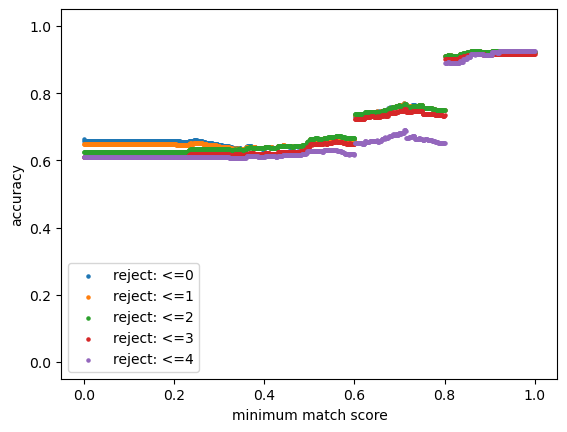

In [125]:
draw_plot(df=bigg_reac_df_pred,
          degen_col='num_query_elements',
          val_col='accuracy',
          x_label='minimum match score',
          save_path=os.path.join(TEMPFIG_DIR, 'bigg_reactions_accuracy_pred_species.png'))

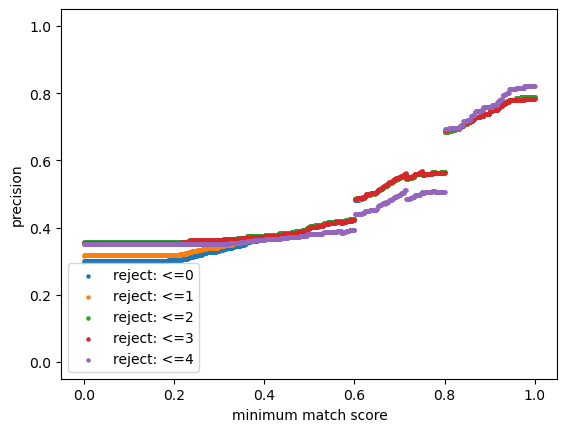

In [126]:
draw_plot(df=bigg_reac_df_pred,
          degen_col='num_query_elements',
          val_col='precision',
          x_label='minimum match score',
          save_path=os.path.join(TEMPFIG_DIR, 'bigg_reactions_precision_pred_species.png'))

In [51]:
# BiGG reactions; using existing species annotations; 
model_names = []
num_rhea_eles = []
num_query_eles = []
num_candidates = []
val_match_scores = []
is_correct_included = []
total_recalls = []
total_precisions = []

# for idx, one_bigg in enumerate(['e_coli_core.xml']):

for idx, one_bigg in enumerate(biggs):
  if idx % 10 == 0:
    print("We are at: %d" % idx)
  one_fpath = os.path.join(BIGG_DIR, one_bigg)
  recom = recommender.Recommender(libsbml_fpath=one_fpath)
  reacs2eval_raw = list(recom.reactions.exist_annotation.keys())
  reacs2eval = []
  for one_r in reacs2eval_raw: 
    comps = recom.reactions.reaction_components[one_r]
    if all([val in recom.species.exist_annotation_formula.keys() \
              for val in comps]):
      reacs2eval.append(one_r)
  res = recom.reactions.predictAnnotation(inp_spec_dict=recom.species.exist_annotation_formula,
                                          inp_reac_list=reacs2eval,
                                          inp_ref_mat=ra.REF_MAT,
                                          update=False)

  refs = {val:recom.reactions.exist_annotation[val] \
          for val in reacs2eval}   
  preds = res['candidates']
  recalls = tools.getRecall(ref=refs, pred=preds, mean=False) 
  precisions = tools.getPrecision(ref=refs, pred=preds, mean=False)    
      
  for one_k in res['match_score']:
    one_reac = one_k
    match_scores = [val[1] for val in res['match_score'][one_k]]
    num_ref_elements = [getRheaElementNum(val) for val in res['candidates'][one_k]]
    mean_num_rhea_elements = np.mean(num_ref_elements)   
    num_query_ele = len(recom.reactions.reaction_components[one_reac])
    num_cands = len(match_scores)
    mean_match_score = np.mean(match_scores)
    model_names.append(one_bigg)
    num_rhea_eles.append(mean_num_rhea_elements)
    num_query_eles.append(num_query_ele)
    num_candidates.append(num_cands)
    val_match_scores.append(mean_match_score)
    if any(set(res['candidates'][one_k]).intersection(recom.reactions.exist_annotation[one_k])):
      is_correct_included.append(1)
    else:
      is_correct_included.append(0)
    
    total_recalls.append(recalls[one_reac])
    total_precisions.append(precisions[one_reac])

         
bigg_reac_df_exist = pd.DataFrame({'model': model_names,
                                   'mean_num_rhea_elements': num_rhea_eles,
                                   'num_query_elements': num_query_eles,
                                   'num_candidates': num_candidates,
                                   'match_score': val_match_scores,
                                   'accuracy': is_correct_included,
                                   'recall': total_recalls,
                                   'precision': total_precisions})
bigg_reac_df_exist.tail()

We are at: 0
We are at: 10
We are at: 20
We are at: 30
We are at: 40
We are at: 50
We are at: 60
We are at: 70
We are at: 80
We are at: 90
We are at: 100


,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy,recall,precision
106239,iEKO11_1354.xml,5.000000,6,1,1.000000,1,1.0,1.000
106240,iEKO11_1354.xml,4.725000,2,120,0.228325,1,0.5,0.008
106241,iEKO11_1354.xml,5.000000,6,1,1.000000,1,1.0,1.000
106242,iEKO11_1354.xml,5.328571,2,70,0.224329,1,1.0,0.014
106243,iEKO11_1354.xml,5.000000,5,1,1.000000,1,1.0,1.000


In [52]:
len(np.unique(bigg_reac_df_exist['model']))

108

In [54]:
bigg_reac_df_exist.to_csv(os.path.join(ACCURACY_DIR, 'bigg_reactions_plot_data_exist_species.csv'), index=False)

# bigg_reac_test_df_exist = pd.read_csv(os.path.join(ACCURACY_DIR, 'bigg_reactions_plot_data_exist_species.csv'))
# bigg_reac_test_df_exist.shape

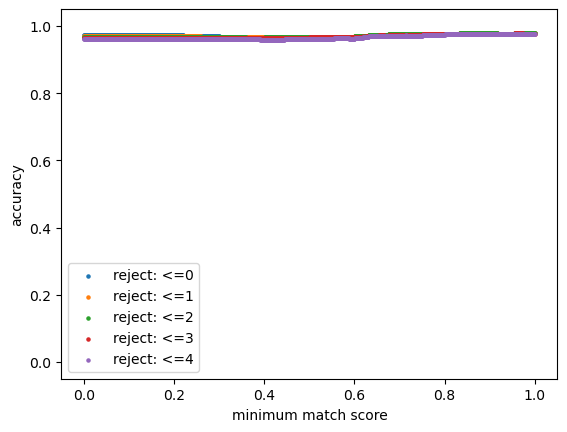

In [127]:
draw_plot(df=bigg_reac_df_exist,
          degen_col='num_query_elements',
          val_col='accuracy',
          x_label='minimum match score',
          save_path=os.path.join(TEMPFIG_DIR, 'bigg_reactions_accuracy_exist_species.png'))

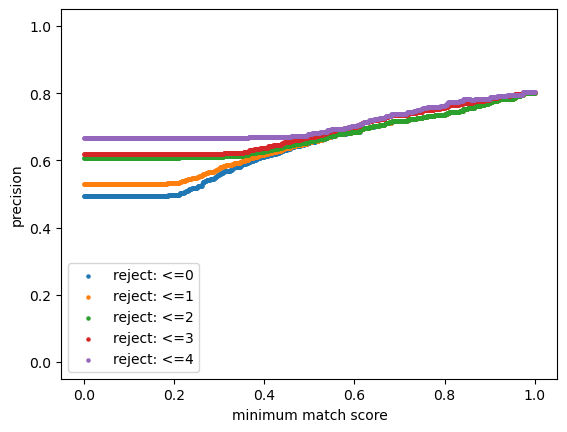

In [128]:
draw_plot(df=bigg_reac_df_exist,
          degen_col='num_query_elements',
          val_col='precision',
          x_label='minimum match score',
          save_path=os.path.join(TEMPFIG_DIR, 'bigg_reactions_precision_exist_species.png'))

## 5. Histograms of match scores

(array([   9.,    6.,   18.,   37.,   57.,  183.,  260.,  329.,  883.,
        3120.]),
 array([0.707 , 0.7363, 0.7656, 0.7949, 0.8242, 0.8535, 0.8828, 0.9121,
        0.9414, 0.9707, 1.    ]),
 <BarContainer object of 10 artists>)

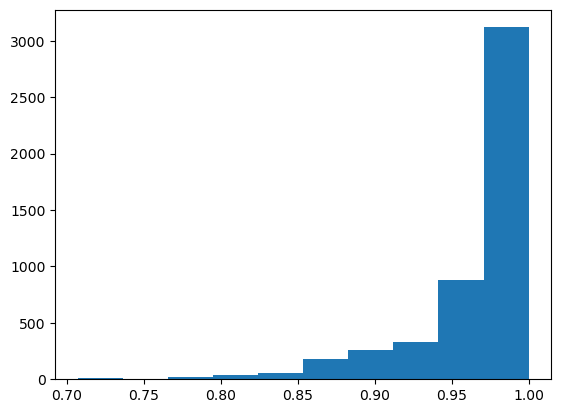

In [57]:
# histograms: biomodels species
plt.hist(biomd_spec_df['match_score'])

In [117]:
def draw_match_score_bar(df, save_path):
  """
  Draw a plot and save it
  
  Parameters
  ----------
  df: pandas.DataFrame
      Should have 'match_score' column
  
  save_path: str
      File path to save it. 
  """
  xs = []
  ys = []
  total_elements = df.shape[0]
  for min_score in np.arange(0.0, 1.01, step=0.01):
    xs.append(min_score)
    ys.append(df[df['match_score']<=min_score].shape[0]/total_elements)
  plt.bar(xs, ys, width=0.008)
  plt.xlim([-0.05, 1.05])
  plt.xlabel("minimum match score")
  plt.ylabel("cumulative probability")

  plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.0)
  plt.show()

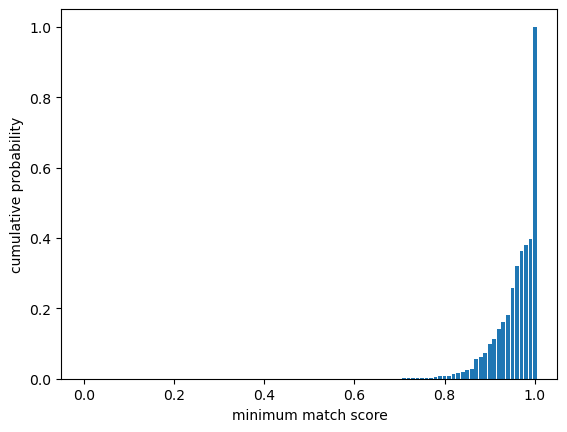

In [118]:
# cumulative distribution of match score: biomodel species
draw_match_score_bar(df=biomd_spec_df,
                     save_path=os.path.join(TEMPFIG_DIR, 'biomd_species_cdf_match_score.png'))

In [100]:
np.max(min_score)

1.0

In [ ]:
cutoffs = np.arange(0.0, 1.05, step=0.001)

In [59]:
biomd_spec_df

,model,name_length,num_candidates,num_formulas,match_score,accuracy,recall,precision
0,BIOMD0000000002.xml,3,2,2,1.000,1,1.0,0.500
1,BIOMD0000000013.xml,5,4,3,0.866,1,1.0,0.333
2,BIOMD0000000013.xml,6,6,6,0.894,0,0.0,0.000
3,BIOMD0000000013.xml,10,2,1,0.849,1,1.0,1.000
4,BIOMD0000000013.xml,6,1,1,0.868,0,0.0,0.000
...,...,...,...,...,...,...,...,...
4897,BIOMD0000000966.xml,4,3,2,1.000,1,1.0,0.500
4898,BIOMD0000000986.xml,33,1,1,0.956,0,0.0,0.000
4899,BIOMD0000000986.xml,46,1,1,0.945,0,0.0,0.000
4900,BIOMD0000000986.xml,46,1,1,0.945,0,0.0,0.000


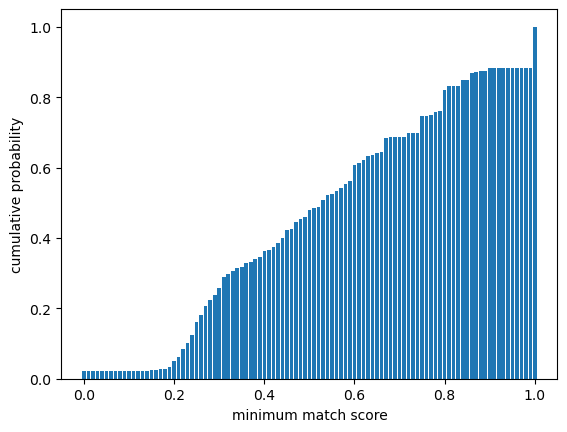

In [119]:
# cumulative distribution of match score: biomodel species
draw_match_score_bar(df=biomd_reac_df,
                     save_path=os.path.join(TEMPFIG_DIR, 'biomd_reactions_cdf_match_score.png'))

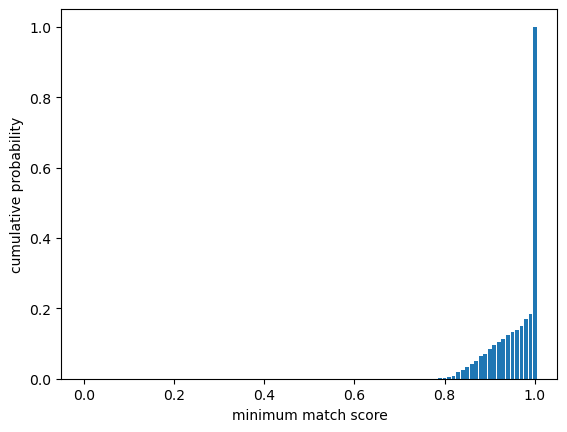

In [120]:
# cumulative distribution of match score: biomodel reactions
draw_match_score_bar(df=bigg_spec_df,
                     save_path=os.path.join(TEMPFIG_DIR, 'bigg_species_cdf_match_score.png'))

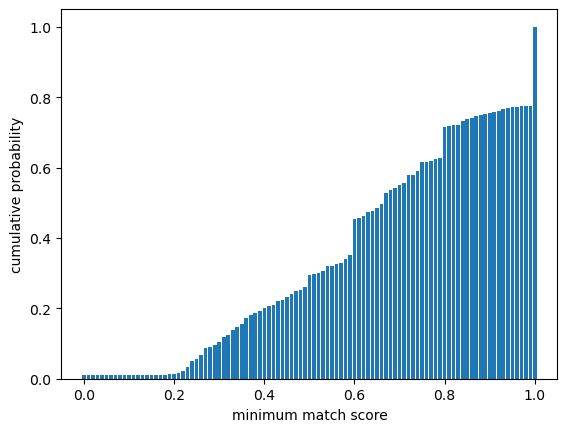

In [121]:
# cumulative distribution of match score: bigg reactions, pred_species
draw_match_score_bar(df=bigg_reac_df_pred,
                     save_path=os.path.join(TEMPFIG_DIR, 'bigg_reactions_predspecies_cdf_match_score.png'))

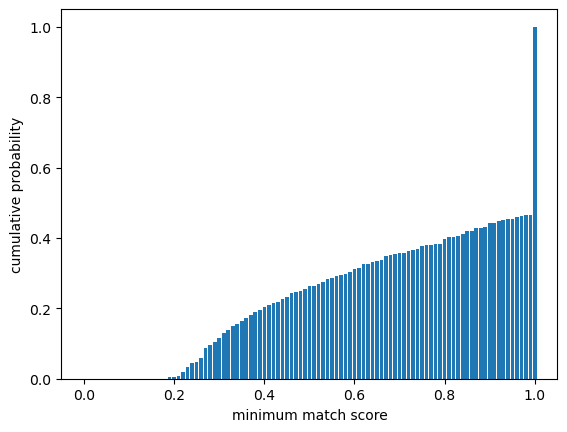

In [122]:
# cumulative distribution of match score: bigg reactions, pred_species
draw_match_score_bar(df=bigg_reac_df_exist,
                     save_path=os.path.join(TEMPFIG_DIR, 'bigg_reactions_existspecies_cdf_match_score.png'))

## *Proportion of null predictions

In [200]:
def proportion_null_pred(df):
  """
  Compute proportion of null predictions
  
  Parameters
  ----------
  df: pandas.DataFrame
      Should have 'match_score' column
  """
  xs = []
  ys = []
  total_elements = df.shape[0]
  for min_score in np.arange(1.00, 0.45, step=-0.05):
    xs.append(min_score)
    predicted_obs = df[df['match_score']>=min_score].shape[0]
    ys.append(1.0 - predicted_obs/total_elements)
  comb_list = list(zip(xs, ys))
  for tup in comb_list:
    # print("%.02f: %.02f" % (tup[0], tup[1]))
    print("%.02f" % (tup[1]))
  return comb_list

In [205]:
res = proportion_null_pred(df=bigg_reac_df_pred)

0.77
0.77
0.75
0.74
0.63
0.59
0.55
0.48
0.35
0.32
0.28


In [218]:
1 - df[df['match_score']>=0.8].shape[0] / df.shape[0]

0.00713994288045694

## "Exactness" plots

In [225]:
EXACTNESS_DIR = os.path.join(TEMPFIG_DIR, 'plots/exactness_scatter')

In [266]:
def draw_exact_plot(df, degen_col, val_col, x_label, save_path):
  """
  Draw an exactness pot and save it
  
  Parameters
  ----------
  df: pandas.DataFrame
  
  degen_col: str
      Column name for degenerate case
      
  val_col: str
      Column name to compute exactness
      
  x_lavel: str
      Name of X axis
  
  save_path: str
      File path to save it. 
  """
  cutoffs = np.arange(0.0, 1.05, step=0.001)
  vals = dict()
  for one_degen in range(0, 5):
    ys = []
    xs = []
    val_tuples = []
    cut_df = df[df[degen_col]>one_degen]
    for one_c in cutoffs:
      xs.append(one_c)
      sub_df = cut_df[cut_df['match_score']>=one_c]
      ave_exactness = np.mean(1/sub_df[val_col])
      ys.append(ave_exactness)
      # val_tuples.append((one_c, ave_exactness))
    vals[str(one_degen)] = val_tuples
    plt.scatter(xs, ys, s=5, label='reject: <=%d'%one_degen)
  plt.legend(loc='lower left')
  plt.ylim([-0.05,1.05])
  plt.xlabel(x_label)
  plt.ylabel('exactness')
  plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.0)
  plt.show()

In [271]:
biomd_reac_df

,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy,recall,precision
0,BIOMD0000000003.xml,4.650943,1,106,0.242528,0,0.0,0.000
1,BIOMD0000000003.xml,4.650943,1,106,0.242528,0,0.0,0.000
2,BIOMD0000000004.xml,4.693548,2,248,0.233302,0,0.0,0.000
3,BIOMD0000000004.xml,4.693548,2,248,0.233302,0,0.0,0.000
4,BIOMD0000000005.xml,4.272727,2,22,0.292455,0,0.0,0.000
...,...,...,...,...,...,...,...,...
2183,BIOMD0000000725.xml,4.035978,4,1084,0.272489,1,1.0,0.001
2184,BIOMD0000000725.xml,5.000000,4,2,0.400000,0,0.0,0.000
2185,BIOMD0000000725.xml,5.703704,6,27,0.537778,0,0.0,0.000
2186,BIOMD0000000725.xml,3.607407,2,405,0.328622,0,0.0,0.000


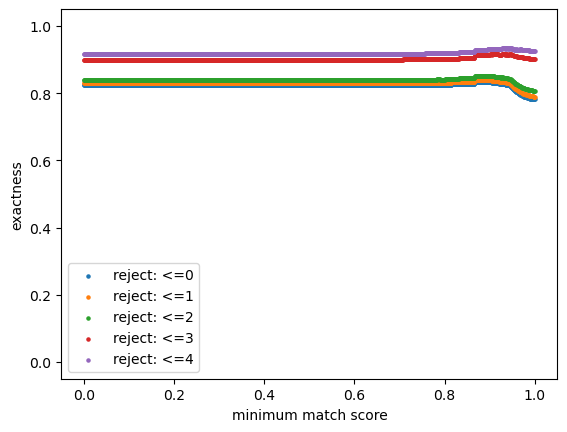

In [272]:
draw_exact_plot(df=biomd_spec_df,
                degen_col='name_length',
                val_col='num_formulas',
                x_label='minimum match score',
                save_path=os.path.join(EXACTNESS_DIR, 'biomd_species_exactness.png'))

In [273]:
# almost same as precision, but exactness has a much higher starting point; 
# some valules have large predicted sets (and it still has a correct valule)

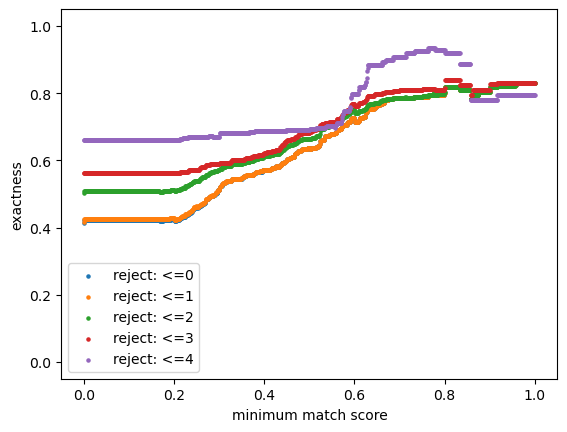

In [274]:
draw_exact_plot(df=biomd_reac_df,
                degen_col='num_query_elements',
                val_col='num_candidates',
                x_label='minimum match score',
                save_path=os.path.join(EXACTNESS_DIR, 'biomd_reactions_exactness.png'))

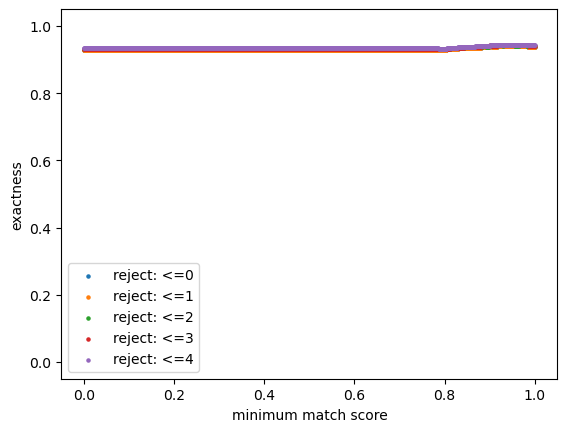

In [275]:
draw_exact_plot(df=bigg_spec_df,
                degen_col='name_length',
                val_col='num_formulas',
                x_label='minimum match score',
                save_path=os.path.join(EXACTNESS_DIR, 'bigg_species_exactness.png'))

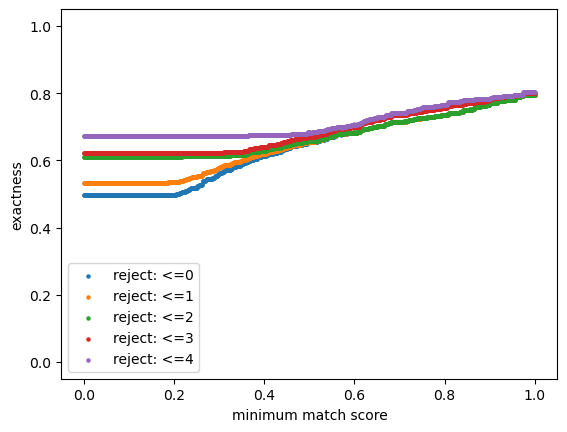

In [276]:
draw_exact_plot(df=bigg_reac_df_exist,
                degen_col='num_query_elements',
                val_col='num_candidates',
                x_label='minimum match score',
                save_path=os.path.join(EXACTNESS_DIR, 'bigg_reactions_exactness_exist_species.png'))

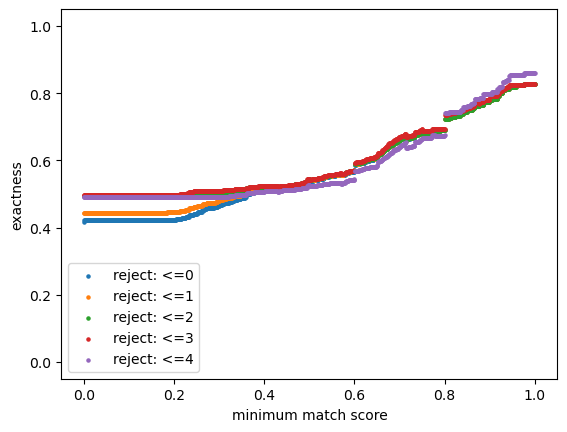

In [277]:
draw_exact_plot(df=bigg_reac_df_pred,
                degen_col='num_query_elements',
                val_col='num_candidates',
                x_label='minimum match score',
                save_path=os.path.join(EXACTNESS_DIR, 'bigg_reactions_exactness_pred_species.png'))

## All Combined Bar plots

In [278]:
COMB_BARS_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/AMAS_suppl/figure_files/temp/plots/all_comb_bars'

In [402]:
plot_min_scores = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

def getCombData(df,
                degen_col,
                degen_cut,
                val_col,
                min_scores=plot_min_scores):
  """
  Get data to draw bar plots describing
  accuracy, exactness, and nonempty. 
  
  
  Parameters
  ----------
  df: pandas.DataFrame
  
  degen_col: str
      Column name for degenerate case

  degen_cut: int
      Number of degenerate cases
      (only observations with higher values
      willl be chosen)

  val_col: str
      Column name to compute exactness
      
  min_scores: list-float
      List of minimum match scores
      
  Returns
  -------
  pandas.DataFrame
  """
  min_accuracy = []
  min_exactness = []
  prop_nonempty = []
  cut_df = df[df[degen_col]>degen_cut]
  for one_c in min_scores:
    sub_df = cut_df[cut_df['match_score']>=one_c]
    min_accuracy.append(np.mean(sub_df['accuracy']))
    min_exactness.append(np.mean(1/sub_df[val_col]))
    prop_nonempty.append(sub_df.shape[0]/cut_df.shape[0])
  res_dict = {'minimum match score': min_scores,
              'accuracy': min_accuracy,
              'exactness': min_exactness,
              'nonempty': prop_nonempty}
  comb_df = pd.DataFrame(res_dict)
  return comb_df

def getCombBars(df, save_path):
  """
  Draw combined bar graph
  and save it. 
  
  Parameters
  ----------
  df: pandas.DataFrame
  
  save_path: str
  """
  min_scores=[str(val) for val in plot_min_scores]
  ind = np.arange(len(min_scores))
  # Figure size
  plt.figure(figsize=(10,5))
  # Width of a bar 
  width = 0.17       

  # Plotting
  plt.bar(ind, df['accuracy'], width, label='accuracy')
  plt.bar(ind + width + 0.01, df['exactness'], width, label='exactness')
  plt.bar(ind + width*2 + 0.02, df['nonempty'], width, label='nonempty')
  plt.xticks(ind + width + 0.01, min_scores)
  plt.ylim([0,1.23])
  plt.yticks(np.arange(0.0, 1.2, step=0.2))
  plt.xlabel('minimum match score')
  plt.legend()
  plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.0)
  plt.show()

In [403]:
bars_biomd_spec = getCombData(df=biomd_spec_df,
                  degen_col='name_length',
                  degen_cut=2,
                  val_col='num_formulas')

bars_bigg_spec =  getCombData(df=bigg_spec_df,
                  degen_col='name_length',
                  degen_cut=2,
                  val_col='num_formulas')

bars_biomd_reac = getCombData(df=biomd_reac_df,
                  degen_col='num_query_elements',
                  degen_cut=2,
                  val_col='num_candidates')

bars_bigg_reac_exist = getCombData(df=bigg_reac_df_exist,
                       degen_col='num_query_elements',
                       degen_cut=2,
                       val_col='num_candidates')

bars_bigg_reac_pred = getCombData(df=bigg_reac_df_pred,
                      degen_col='num_query_elements',
                      degen_cut=2,
                      val_col='num_candidates')



In [404]:
bars_biomd_spec

,minimum match score,accuracy,exactness,nonempty
0,0.40,0.612794,0.839696,1.000000
1,0.50,0.612794,0.839696,1.000000
2,0.60,0.612794,0.839696,1.000000
3,0.70,0.612794,0.839696,1.000000
4,0.80,0.616976,0.840514,0.993222
5,0.90,0.666823,0.850514,0.903410
6,0.95,0.773660,0.838373,0.743063


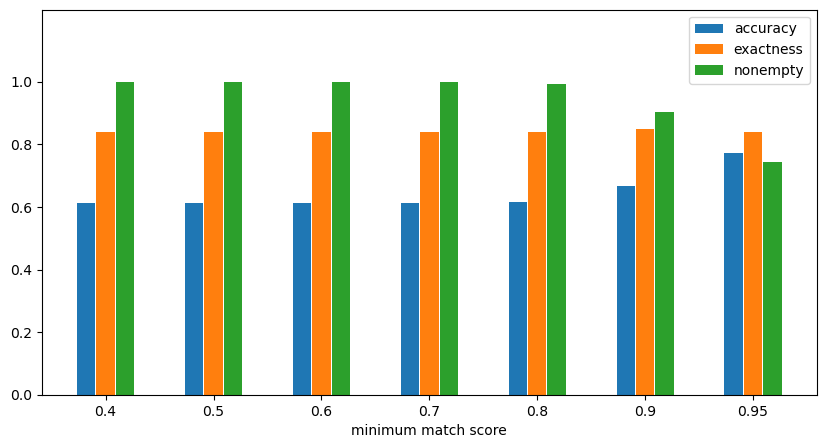

In [405]:
getCombBars(df=bars_biomd_spec,
            save_path=os.path.join(COMB_BARS_DIR, 'biomd_spec_bars.png'))

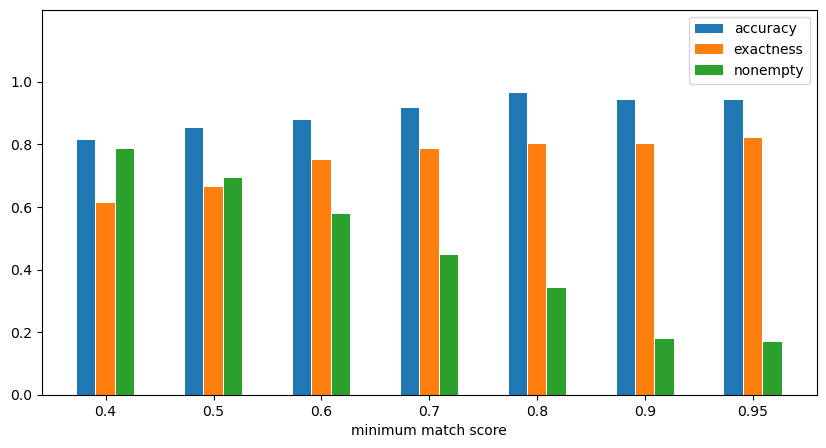

In [406]:
getCombBars(df=bars_biomd_reac,
            save_path=os.path.join(COMB_BARS_DIR, 'biomd_reac_bars.png'))

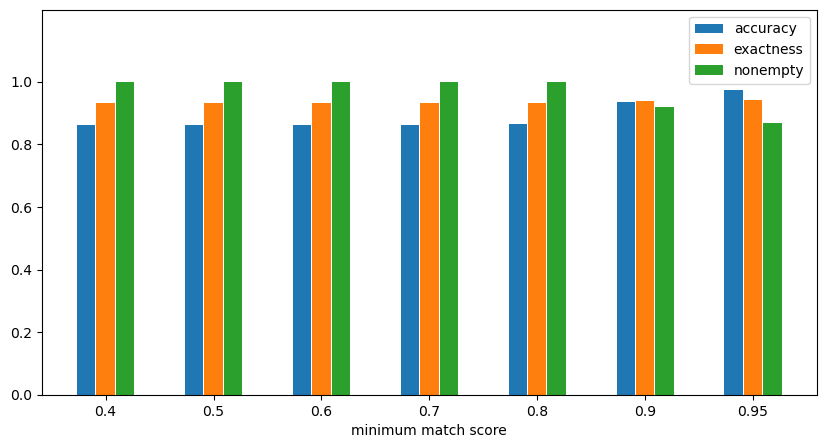

In [407]:
getCombBars(df=bars_bigg_spec,
            save_path=os.path.join(COMB_BARS_DIR, 'bigg_spec_bars.png'))

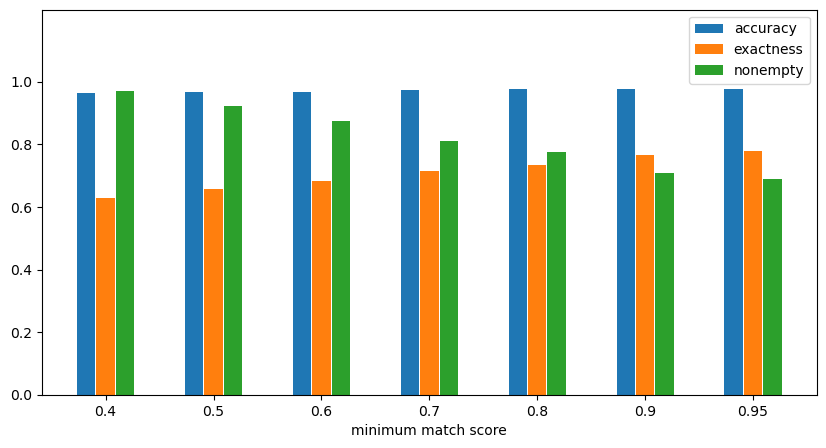

In [408]:
getCombBars(df=bars_bigg_reac_exist,
            save_path=os.path.join(COMB_BARS_DIR, 'bigg_reac_bars_exist_species.png'))

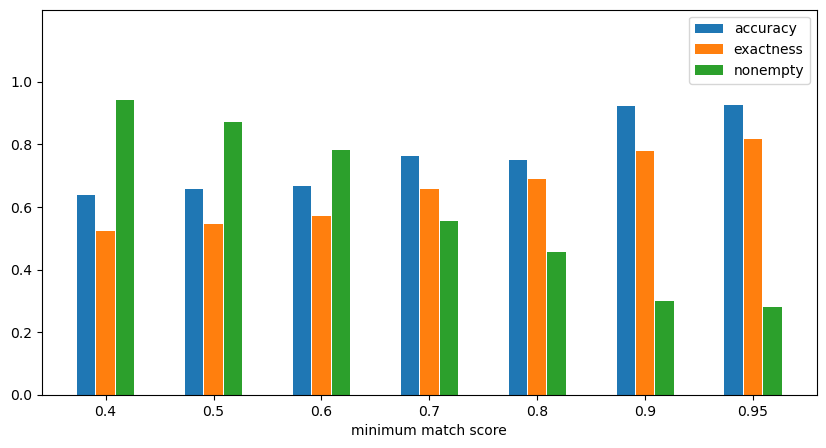

In [409]:
getCombBars(df=bars_bigg_reac_pred,
            save_path=os.path.join(COMB_BARS_DIR, 'bigg_reac_bars_pred_species.png'))

## Another plot: accuracy for four cases (pred_species) with match score 0.9, reject=2

In [35]:
def getAccuracyVal(df,
                   len_col,
                   cutoff=0.9,
                   reject=2):
    """
    Get accuracy score
    
    Parameters
    ----------
    df: pandas.DataFrame
    
    cutoff: float
    
    reject: int
    
    Returns
    -------
    : float
    """
    sub_df = df[(df[len_col]>reject) & (df['match_score']>=cutoff)]
    return np.round(np.mean(sub_df['accuracy']), 2)

In [36]:
biomd_spec_ac = getAccuracyVal(df=biomd_spec_df,
                               len_col='name_length',
                               cutoff=0.95)
print(biomd_spec_ac)

biomd_reac_ac = getAccuracyVal(df=biomd_reac_df,
                               len_col='num_query_elements',
                               cutoff=0.95)
print(biomd_reac_ac)

bigg_spec_ac = getAccuracyVal(df=bigg_spec_df,
                               len_col='name_length',
                               cutoff=0.95)
print(bigg_spec_ac)

bigg_reac_ac = getAccuracyVal(df=bigg_reac_df_pred,
                               len_col='num_query_elements',
                               cutoff=0.95)
print(bigg_reac_ac)

0.77
0.94
0.97
0.92


,model,name_length,num_candidates,num_formulas,match_score,accuracy,recall,precision
0,BIOMD0000000002.xml,3,2,2,1.000,1,1.0,0.500
1,BIOMD0000000013.xml,5,4,3,0.866,1,1.0,0.333
2,BIOMD0000000013.xml,6,6,6,0.894,0,0.0,0.000
3,BIOMD0000000013.xml,10,2,1,0.849,1,1.0,1.000
4,BIOMD0000000013.xml,6,1,1,0.868,0,0.0,0.000


In [9]:
biomd_reac_df.head()

,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy,recall,precision
0,BIOMD0000000003.xml,4.650943,1,106,0.242528,0,0.0,0.0
1,BIOMD0000000003.xml,4.650943,1,106,0.242528,0,0.0,0.0
2,BIOMD0000000004.xml,4.693548,2,248,0.233302,0,0.0,0.0
3,BIOMD0000000004.xml,4.693548,2,248,0.233302,0,0.0,0.0
4,BIOMD0000000005.xml,4.272727,2,22,0.292455,0,0.0,0.0


In [10]:
bigg_spec_df.head()

,model,name_length,num_candidates,num_formulas,match_score,accuracy,recall,precision
0,iCHOv1.xml,23,3,1,1.000,1,1.0,1.0
1,iCHOv1.xml,23,3,1,1.000,1,1.0,1.0
2,iCHOv1.xml,25,1,1,1.000,1,1.0,1.0
3,iCHOv1.xml,23,3,1,1.000,1,1.0,1.0
4,iCHOv1.xml,27,1,1,0.958,0,0.0,0.0


In [11]:
bigg_reac_df_pred.head()

,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy,recall,precision
0,iCHOv1.xml,5.0,4,2,1.0,0,0.0,0.0
1,iCHOv1.xml,5.0,5,2,0.8,0,0.0,0.0
2,iCHOv1.xml,4.0,4,1,1.0,1,0.5,1.0
3,iCHOv1.xml,5.0,5,2,0.8,0,0.0,0.0
4,iCHOv1.xml,4.0,5,1,1.0,0,0.0,0.0
